In [31]:
# imports
import numpy as np
import pandas as pd
import glob
import os

# original dataset analysis

The link for dataset is: https://www.kaggle.com/competitions/towardsai-x-whitebox-startup-challenge/data. 

In [ ]:
# this our data directory (we did not upload it on git)
data_dir = 'History'  

# Discover all CSV files
csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
print(f"Found {len(csv_files)} CSV files:")

# Load and rename each close column to its ticker symbol
dfs = []
for file in csv_files:
    ticker = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(
        file,
        usecols=['timestamp', 'close'],
        parse_dates=['timestamp'],
        date_format=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')
    )
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'close': ticker}, inplace=True)
    dfs.append(df)

# Concatenate into one DataFrame
panel_df = pd.concat(dfs, axis=1).sort_index()
panel_df.index = pd.to_datetime(panel_df.index)


Found 212 CSV files:


In [33]:
# Basic info
print("Time range:", panel_df.index.min(), "to", panel_df.index.max())

Time range: 2015-12-01 14:30:00 to 2023-01-11 21:00:00


In [34]:
# Duplicate timestamp check
n_duplicates = panel_df.index.duplicated().sum()
print("Duplicate timestamps:", n_duplicates)

Duplicate timestamps: 0


In [35]:
# Missingness overview
missing_pct_by_asset = panel_df.isna().mean() * 100
missing_pct_by_time  = panel_df.isna().mean(axis=1) * 100

print("\nTop 10 assets by % missing data:")
print(missing_pct_by_asset.sort_values(ascending=False).head(10))

print("\nTop 10 timestamps by % missing assets:")
print(missing_pct_by_time.sort_values(ascending=False).head(10))


Top 10 assets by % missing data:
TSLL    94.060471
WBD     89.332837
NU      84.884394
RIVN    83.616660
EUSB    77.960458
DNA     76.097117
COIN    75.563552
RBLX    74.250321
WE      73.057038
AFRM    72.382843
dtype: float64

Top 10 timestamps by % missing assets:
timestamp
2015-12-24 19:30:00    95.754717
2015-12-24 20:00:00    94.811321
2015-12-24 19:15:00    94.339623
2015-12-24 20:30:00    93.867925
2015-12-24 19:45:00    93.396226
2015-12-24 20:15:00    92.924528
2015-12-24 21:00:00    91.981132
2018-07-03 20:30:00    91.981132
2015-12-24 20:45:00    91.509434
2016-11-25 20:15:00    91.509434
dtype: float64


In [36]:
# Identify large time gaps in the index
#   (assumes regular 15-minute sampling)
expected_index = pd.date_range(
    start=panel_df.index.min(),
    end=panel_df.index.max(),
    freq='15min'
)

missing_timestamps = expected_index.difference(panel_df.index)
print("\nNumber of missing timestamps in series:", len(missing_timestamps))
if len(missing_timestamps)>0:
    print("Sample missing timestamps:", missing_timestamps[:5])


Number of missing timestamps in series: 201081
Sample missing timestamps: DatetimeIndex(['2015-12-01 21:15:00', '2015-12-01 21:30:00',
               '2015-12-01 21:45:00', '2015-12-01 22:00:00',
               '2015-12-01 22:15:00'],
              dtype='datetime64[ns]', freq=None)


In [37]:
# Descriptive statistics and outlier counts
stats = panel_df.describe().T
stats['missing_pct'] = missing_pct_by_asset
# compute outliers as |z| > 3
z_scores = panel_df.sub(panel_df.mean()).div(panel_df.std())
stats['outlier_count'] = (z_scores.abs() > 3).sum()
print("\nDescriptive stats + missing% + outlier counts:")
print(stats[['count','mean','std','min','25%','50%','75%','max','missing_pct','outlier_count']])



Descriptive stats + missing% + outlier counts:
        count        mean         std     min     25%        50%       75%  \
CSCO  47064.0   38.881408   10.113300  18.040  28.550   40.53000   46.1300   
SPXU  47679.0  183.131972  180.443332  12.000  21.820  141.49000  272.5000   
UAL   46525.0   59.487848   18.868761  18.860  44.145   56.68000   75.6800   
TLRY  30088.0   25.525223   31.461922   2.440   6.315   12.97645   27.5695   
SPLG  35221.0   42.916023   17.045143  24.580  31.060   38.07000   48.1900   
...       ...         ...         ...     ...     ...        ...       ...   
PDBC  41882.0   10.187992    2.488072   6.383   8.708    9.30900   10.9200   
EELV  33579.0   20.258105    2.405862  14.160  18.450   20.44000   21.7100   
SPTL  41832.0   42.929804   12.468320  26.760  32.420   39.02000   45.6600   
KWEB  43423.0   44.769252   13.805697  17.805  34.480   42.51000   52.4800   
PPL   44611.0   26.194053    2.317746  16.020  24.730   26.22000   27.8800   

          max  

# cleaning and data imputing

We decided to work with daily frequency, suitable for regime detection and daily algo trading strategies. 

In [38]:
# Resample to daily last known close for each ticker
daily_close = panel_df.resample('1D').mean()

Many rows and columns have very high percentage of missing values, for those we decided to drop them because they could not be leveraged.

In [39]:
# Drop days with too many missing values (e.g., weekends, holidays)
daily_close = daily_close.dropna(thresh=int(0.8 * daily_close.shape[1]))

# Drop assets that are empty most of the time
daily_close = daily_close.dropna(axis=1, thresh=int(0.8 * daily_close.shape[0]))

In [40]:
missing_by_asset = daily_close.isna().mean() * 100
print("Top 10 assets by % missing:")
print(missing_by_asset.sort_values(ascending=False).head(10))


Top 10 assets by % missing:
IQ      16.655149
BILI    16.586040
VXX     14.098134
USHY    12.508639
SUSC     8.707671
IGSB     5.252246
ESGU     4.699378
JPST     3.800968
SPXS     0.760194
CVNA     0.691085
dtype: float64


In [41]:
missing_by_day = daily_close.isna().mean(axis=1) * 100
print("Top 10 days by % missing assets:")
print(missing_by_day.sort_values(ascending=False).head(10))


Top 10 days by % missing assets:
timestamp
2017-03-02    5.05618
2017-04-06    5.05618
2017-05-16    5.05618
2017-07-21    5.05618
2017-03-08    5.05618
2017-04-28    5.05618
2017-04-13    5.05618
2017-04-25    5.05618
2017-03-23    5.05618
2017-03-21    5.05618
dtype: float64


In [ ]:
def print_remaining_missing_values(df):
    print("Overall % missing:", round(df.isna().mean().mean() * 100, 2), "%")
    print("Shape:", df.shape)
    print("Number of fully missing rows:", df.isna().all(axis=1).sum())
    print("Number of fully missing columns:", df.isna().all().sum())

In [49]:
print_remaining_missing_values(daily_close)

Overall % missing: 0.47 %
Shape: (1447, 178)
Number of fully missing rows: 0
Number of fully missing columns: 0


In [50]:
daily_interp = daily_close.interpolate(method='time', limit=5)
print_remaining_missing_values(daily_interp)

Overall % missing: 0.39 %
Shape: (1447, 178)
Number of fully missing rows: 0
Number of fully missing columns: 0


Even after interpolation we still have some missing values, let's inspect further.

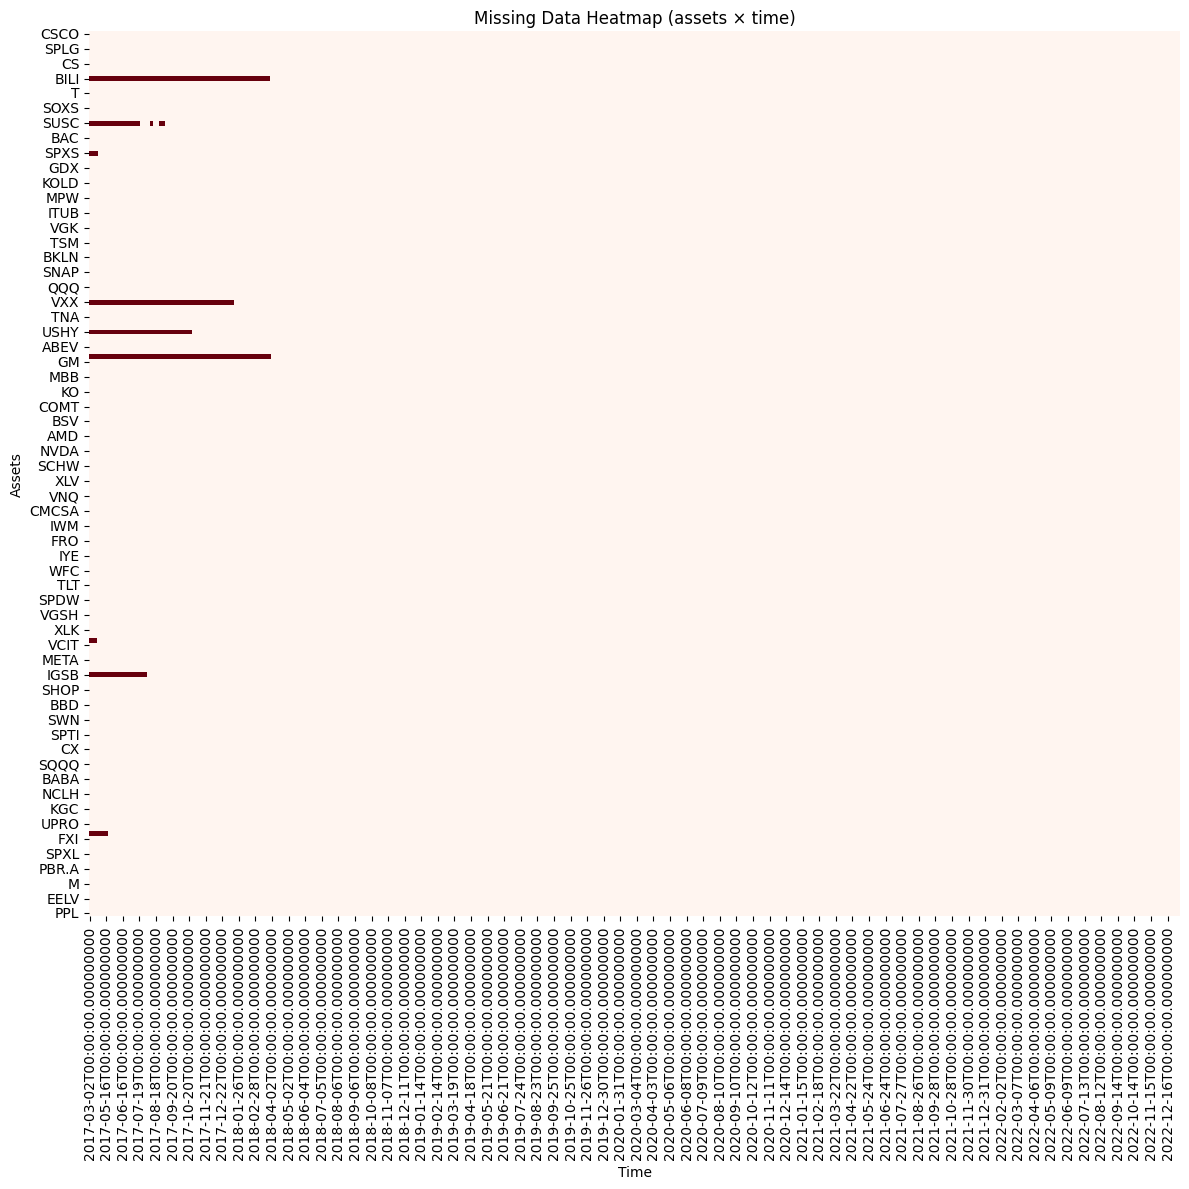

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_map = daily_interp.isna().astype(int)

plt.figure(figsize=(12, 12))
sns.heatmap(missing_map.T, cmap='Reds', cbar=False)
plt.title("Missing Data Heatmap (assets × time)")
plt.xlabel("Time")
plt.ylabel("Assets")
plt.tight_layout()
plt.show()


As expected, the missing values are in blocks, we can either start from a more recent timestamp or drop the concerned stocks. Since there are only few such stocks, let's just drop them.

In [45]:
def max_consecutive_nans(series):
    is_na = series.isna()
    return (is_na != is_na.shift()).cumsum()[is_na].value_counts().max()

max_gaps = daily_interp.apply(max_consecutive_nans)
tickers_to_drop = max_gaps[max_gaps > 5].index.tolist()  # e.g. >10 days missing in a row

print("Tickers to drop due to long gaps:", tickers_to_drop)
cleaned = daily_interp.drop(columns=tickers_to_drop)

Tickers to drop due to long gaps: ['BILI', 'SUSC', 'SPXS', 'VXX', 'USHY', 'IQ', 'CVNA', 'IGSB', 'JPST']


In [46]:
print("Overall % missing:", round(cleaned.isna().mean().mean() * 100, 2), "%")
print("Shape:", cleaned.shape)
print("Number of fully missing rows:", cleaned.isna().all(axis=1).sum())
print("Number of fully missing columns:", cleaned.isna().all().sum())


Overall % missing: 0.0 %
Shape: (1447, 169)
Number of fully missing rows: 0
Number of fully missing columns: 0


Finally we don't have missing values. 

In [52]:
cleaned.to_csv('data/data_preprocessed.csv')